# In this notebook:
### We will train the Conditional GAN on the Fashion-MNIST dataset. 
### For the training we also will up TensorBoard where we can check intermediate results from generator and loss plots.
### After training, we will evaluate final generator with FID Metric.

## Some references:
> #### Training of the Conditional GAN, for more details refer to paper: https://arxiv.org/pdf/1411.1784.pdf
> #### FID Metric. Calculate how good final generator with FID metric, for more details refer to paper: https://arxiv.org/abs/1706.08500

# Import libraries what we will use in this notebook

In [3]:
!pip install tensorflow

     -------------------------------------- 266.3/266.3 MB 9.1 MB/s eta 0:00:00
     ---------------------------------------- 3.6/3.6 MB 23.3 MB/s eta 0:00:00
     --------------------------------------- 14.2/14.2 MB 25.1 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 32.1 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB ? eta 0:00:00
     ---------------------------------------- 6.0/6.0 MB 29.5 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 9.7 MB/s eta 0:00:00
     -------------------------------------- 124.6/124.6 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 16.7 MB/s eta 0:00:00
     ------------------------------------- 895.7/895.7 kB 18.8 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.7 MB/s eta 0:00:00
     ------------------------------------- 439.2/439.2 kB 26.8 MB/s eta 0:00:00
     ---------------------------------------- 175.4/1


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import struct
import pandas as pd
import os
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Define global constants

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Noise shape for generator
NOISE_SIZE = 128
BATCH_SIZE = 56
NUM_CLASSES = 10
EMBEDDING_SIZE = 48
# Image size and number of channels
H, W, C = (28, 28, 1)

# Setup TensorBoard
tensor_board_writer = SummaryWriter('./logs/')

# Setup TensorBoard
## Download Ngrog in order to open TensorBoard in your browser

In [3]:
# Download Ngrok to tunnel the tensorboard port to an external port
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

# Run tensorboard as well as Ngrox (for tunneling as non-blocking processes)
import os
import multiprocessing


pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir ./logs/ --load_fast true --host 0.0.0.0 --port 6006 &",
                        "./ngrok http 6006 &"
                        ]]

--2022-02-03 14:07:56--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 52.202.168.65, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  13.9MB/s    in 0.9s    

2022-02-03 14:07:58 (13.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


## Get link to TensorBaord
### In most cases it starts as https://xxxx.ngrok.io
### You can grabe it from print info below

In [6]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Your link: ', json.load(sys.stdin)['tunnels'][0]['public_url'])"

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.


# Read data from CSV file

In [5]:
# Read train images
df = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
# Create np array from csv
df_as_np = np.asarray(df)
# Wrap images and labels
labels_mnist, data = (
    df_as_np[:, 0],                                                  # First row - labels
    df_as_np[:, 1:].reshape(-1, H, W, C)                             # Other rows - images
)
# Read test images
df = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv')
# Create np array from csv
df_as_np = np.asarray(df)
# Wrap images and labels
test_labels_mnist, test_data = (
    df_as_np[:, 0],                                                  # First row - labels
    df_as_np[:, 1:].reshape(-1, H, W, C)                             # Other rows - images
)
print('Train data: ', data.shape, labels_mnist.shape)
print('Test data: ', test_data.shape, test_labels_mnist.shape)

2022-02-03 14:08:01.520389: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
TensorBoard 2.6.0 at http://0.0.0.0:6006/ (Press CTRL+C to quit)


Train data:  (60000, 28, 28, 1) (60000,)
Test data:  (10000, 28, 28, 1) (10000,)


# Define image generator (data loader)

In [6]:
# Define class with super-class Dataset
# We must implement two methods (getitem__ and __len__): 
#     __getitem__ - gives possibility to apply indexing for the instance of class FashionDataset
#     __len__ - gives possibility to take size of overall dataset
# This methods need in order to use DataLoader
class FashionDataset(Dataset):

    def __init__(self, data, data_y, transform = None, H = 28, W = 28, C = 1):
        self._data = np.asarray(data, dtype=np.float32).reshape(-1, H, W, C)
        self._data_y = np.asarray(data_y, dtype=np.int64).reshape(-1)
        self._transform = transform

    def __getitem__(self, index):
        single_data = self._data[index]
        single_label = self._data_y[index]
        if self._transform is not None:
            single_data = self._transform(single_data)
        return single_data, single_label
    
    def __len__(self):
        return len(self._data)

# Create instaince of data loader in order to load and create batches of data
# Also we can specify number of workers in loader which can speed up process of 
# preparing data. We leave it as it is, with default value.
# For more info refer to original docs.
train_set = FashionDataset(
    data, labels_mnist, transform=transforms.Compose(
        # Transform data into Tensor and normalize data into range [-1, 1]
        [transforms.ToTensor(), transforms.Normalize(128, 128)]
    ),
    H=H, W=W, C=C
)
# Create data loader
train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, 
    shuffle=True, drop_last=True
)

## Test train loader. 
### Print batch of images

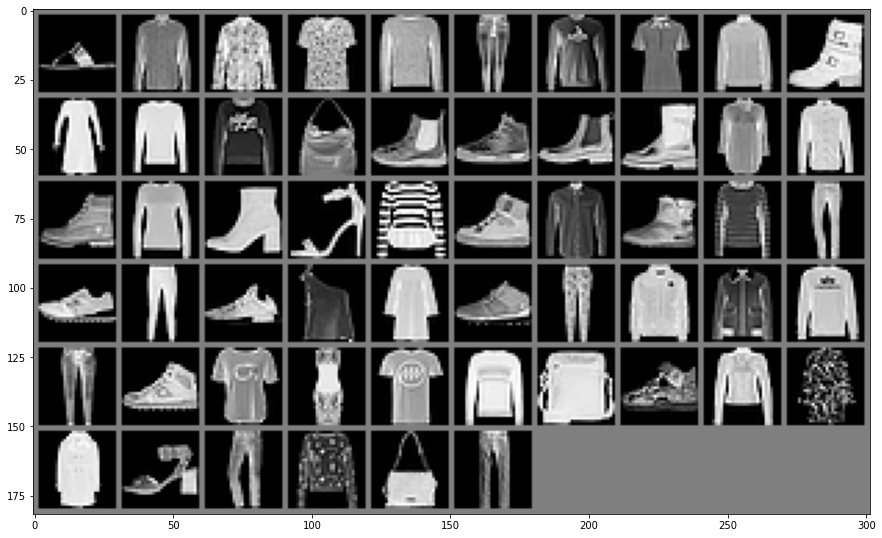

In [7]:
# Test loader
batch_d, _ = next(iter(train_loader))
grid = torchvision.utils.make_grid(batch_d, nrow=10)

plt.figure(figsize=(15, 20))
grid_image = np.transpose(grid, (1, 2, 0)).numpy()
grid_image = (grid_image + 1.0) / 2.0 # [-1, 1] --> [0, 1]
plt.imshow(grid_image)

# Define Models

## Define some utils for layers/models

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Define Generator model

In [9]:
class GeneratorNN(nn.Module):

    def __init__(
            self, noise_size: tuple, num_classes: int, embedding_size: int, 
            map_noise_to: int = 128, start_size: int = 7):
        super(GeneratorNN, self).__init__()
        self._start_size = start_size
        self._embed_input = nn.Sequential(
            nn.Embedding(num_classes, embedding_size),
            nn.Linear(embedding_size, start_size * start_size),
        ) # 7
        
        self._map_noise_to = map_noise_to
        self._noise_input = nn.Sequential(
            nn.Linear(noise_size, map_noise_to * start_size * start_size),
            #nn.BatchNorm1d(512, momentum=0.8, track_running_stats=False),
            nn.LeakyReLU(0.2, inplace=True),
        ) # 7
        self._model = nn.Sequential(
            nn.ConvTranspose2d(map_noise_to + 1, 128, kernel_size=4, stride=2, padding=1), # 14
            #nn.BatchNorm1d(128, momentum=0.8, track_running_stats=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),  # 28
            #nn.BatchNorm1d(128, momentum=0.8, track_running_stats=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 1, kernel_size=7, padding=3),
            nn.Tanh()
        )
    
    def forward(self, x, y):
        n_batch = x.shape[0]
        y = self._embed_input(y).view(n_batch, 1, self._start_size, self._start_size)
        x = self._noise_input(x).view(n_batch, self._map_noise_to, self._start_size, self._start_size)
        x = torch.cat([y, x], dim=1)
        x = self._model(x)
        return x

## Create instance of generator model and test it with noise

torch.Size([56, 1, 28, 28])


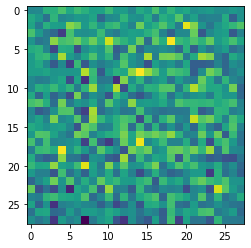

In [10]:
# Generator
gen_nn = GeneratorNN(noise_size=NOISE_SIZE, num_classes=NUM_CLASSES, embedding_size=EMBEDDING_SIZE)
gen_nn.to(device=device)
# Init weights of the model with certain initialization
gen_nn.apply(weights_init)
# Turn on training mode
gen_nn.train()

# Check generator
arr_x = np.random.randn(BATCH_SIZE, NOISE_SIZE).astype(np.float32)
arr_y = np.random.randint(low=0, high=NUM_CLASSES, size=(BATCH_SIZE)).astype(np.int64)
res = gen_nn(torch.tensor(arr_x).to(device=device), torch.tensor(arr_y).to(device=device))
print(res.shape)
plt.imshow( ((res + 1.0) / 2.0)[0].cpu().detach().numpy().transpose(1, 2, 0)[..., 0])

## Define Discriminator model

In [11]:
class DiscriminatorNN(nn.Module):

    def __init__(self, H: int, W: int, C: int, num_classes: int, embedding_size: int):
        super(DiscriminatorNN, self).__init__()
        
        self._h, self._w = H, W
        self._embed_input = nn.Sequential(
            nn.Embedding(num_classes, embedding_size),
            nn.Linear(embedding_size, H * W )
        )
        
        self._net = nn.Sequential(
            nn.Conv2d(C + 1, 128, kernel_size=3, stride=2, padding=1), # 14
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),   # 7
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Dropout(p=0.4),
            nn.Linear(7 * 7 * 128, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, y):
        b = x.shape[0]
        y = self._embed_input(y).view(b, 1, self._h, self._w)
        x = torch.cat([y, x], dim=1)
        return self._net(x)

## Create instance of discriminator model and test it with noise

In [12]:
# Discriminator
disc_nn = DiscriminatorNN(H=H, W=W, C=C, num_classes=NUM_CLASSES, embedding_size=EMBEDDING_SIZE)
disc_nn.to(device=device)
# Init weights of the model with certain initialization
disc_nn.apply(weights_init)
# Turn on training mode
disc_nn.train()

# Check discriminator on noise data
arr_x = np.random.randn(BATCH_SIZE, C, H, W).astype(np.float32)
arr_y = np.random.randint(low=0, high=NUM_CLASSES, size=(BATCH_SIZE)).astype(np.int64)
res = disc_nn(torch.tensor(arr_x, device=device), torch.tensor(arr_y, device=device))
print(res.shape)
res.cpu().detach().numpy()[:5]

torch.Size([56, 1])


array([[0.49389145],
       [0.50343716],
       [0.50265235],
       [0.5133718 ],
       [0.5044046 ]], dtype=float32)

# Training
## Define class which controls training of GAN.
## Main methods: 
> ### `fit` - function which start training of a GAN;
> ### `compile` - Setup optimizers and losses. Must be called first before training.

In [13]:
class TrainGANController:
    
    def __init__(
            self, disc_nn, gen_nn, 
            batch_size, num_classes, noise_size, 
            device = None, tensor_board_writer = None):
        self._disc_nn = disc_nn
        self._gen_nn = gen_nn
        self._batch_size = batch_size
        self._num_classes = num_classes
        self._noise_size = noise_size

        self._is_compiled = False
        self._opt_disc = None
        self._opt_gen = None
        self._loss = None
        self._device = device
        
        self._tensor_board_writer = tensor_board_writer
        self._global_step = 0
        self._global_step_images = 0
    
    def compile(
            self, 
            lr_disc=2e-4, lr_gen=2e-4, 
            beta_params_disc=(0.5, 0.999), beta_params_gen=(0.5, 0.999)):
        # Init opt
        self._opt_disc = torch.optim.Adam(
            self._disc_nn.parameters(), lr=lr_disc, betas=beta_params_disc
        )
        self._opt_gen = torch.optim.Adam(
            self._gen_nn.parameters(), lr=lr_gen, betas=beta_params_gen
        )
        # Losses
        self._loss = nn.BCELoss().to(device=self._device)
        # Set flag, in order to start train
        self._is_compiled = True
    
    def train_step_disc(self, real_data, labels, real_label=0.9, fake_label=0.0):
        # Set real label equal to 0.9 in order to use "Label smoothing"
        # Discriminator can produce better gradients, then this technique is used
        # For more details about label smoothing you can find in the internet 
        
        # For easy access
        device = self._device
        # Train step for discriminator
        # Zero grads
        self._disc_nn.zero_grad()
        # Forward pass for real data
        label = torch.full((self._batch_size,), real_label, dtype=torch.float, device=device)
        fake = torch.full((self._batch_size,), fake_label, dtype=torch.float, device=device)
        # Generate fake stuf
        noise = torch.randn(self._batch_size, self._noise_size, device=device)
        generated_imgs = self._gen_nn(noise, labels)
        # Forward pass real batch through D
        errD_real = self._loss(self._disc_nn(real_data, labels).view(-1), label)
        # Forward pass fake batch through D
        errD_fake = self._loss(self._disc_nn(generated_imgs.detach(), labels).view(-1), fake)
        errD = (errD_fake + errD_real) / 2.0
        errD.backward()
        self._opt_disc.step()
        return errD.cpu().detach().numpy()

    def train_step_gen(self, fake_label=1.0):
        # For easy access
        device = self._device
        # Train step for generator
        # Zero grads
        self._gen_nn.zero_grad()
        # fake labels are real for generator cost
        label = torch.full((self._batch_size,), fake_label, dtype=torch.float, device=device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        # Generate batch of latent vectors
        noise = torch.randn(self._batch_size, self._noise_size, device=device)
        # Take random num classes
        labels_y = torch.randint(low=0, high=self._num_classes, size=(self._batch_size,), device=device)
        # Generate fake image batch with G
        generated_imgs = self._gen_nn(noise, labels_y)
        # Calculate G's loss based on this output
        errG = self._loss(self._disc_nn(generated_imgs, labels_y).view(-1), label)
        # Calculate gradients for G
        errG.backward()
        # Update G
        self._opt_gen.step()
        return errG.cpu().detach().numpy()
    
    def _tb_flush(self):
        if self._tensor_board_writer is None:
            # I.e. tensor board is not used
            return
        self._tensor_board_writer.flush()
    
    def write_tb_info(self, disc_loss, gen_loss):
        if self._tensor_board_writer is None:
            # I.e. tensor board is not used
            return
        
        self._tensor_board_writer.add_scalars(
            'loss',
            {
                'generator loss': gen_loss,
                'discriminator loss': disc_loss,
            },
            global_step=self._global_step
        )
        self._global_step += 1
    
    def generate_images(self, epoch: int, iteration: int, write_to_tb=True):
        # Check generator
        num_data = NUM_CLASSES * NUM_CLASSES
        arr = np.random.randn(num_data, NOISE_SIZE).astype(np.float32)
        labels_arr = np.asarray(
            [min(x, NUM_CLASSES-1)  for _ in range(NUM_CLASSES) for x in range(NUM_CLASSES)],
            dtype=np.int64
        )
        gen_nn.eval()
        res = gen_nn(torch.tensor(arr).to(device=self._device), torch.tensor(labels_arr).to(device=self._device))
        # Unnormed images and plot big figure
        res = ((res + 1.0) / 2.0).cpu().detach().numpy().transpose(0, 2, 3, 1)
        save_name=f'generate_ep{epoch}_it{iteration}.png'
        visualise_sheets_of_images(
            res, NUM_CLASSES, "generated_digits", 
            show_images=True, use_grey=True, save_name=save_name
        )
        if write_to_tb:
            if self._tensor_board_writer is None:
                # I.e. tensor board is not used
                return
            self._tensor_board_writer.add_image(
                'generator result',
                np.array(Image.open(save_name)),
                global_step=self._global_step_images,
                dataformats='HWC'
            )
            self._global_step_images += 1

    def fit(self, data_gen, epoch: int, print_it: int = 400, img_generation_it: int = None):
        if img_generation_it is None:
            # I.e. at the end of epoch
            img_generation_it = len(data_gen) - 1
        
        for i_e in range(epoch):
            for ii_it, (single_data, single_label) in enumerate(data_gen):
                single_data = single_data.to(device=self._device)
                single_label = single_label.to(device=self._device)
                # Train discriminator
                err_d = self.train_step_disc(single_data, single_label)
                # Train generator
                err_g = self.train_step_gen()
                # Write loss info
                self.write_tb_info(err_d, err_g)
                if ii_it != 0 and ii_it % img_generation_it == 0:
                    # Generate imgs
                    self.generate_images(epoch=epoch, iteration=ii_it)
                
                if ii_it % print_it == 0:
                    self._tb_flush()
                    # Print info
                    print(
                        f'Epoch: {str(i_e+1).zfill(2)}/{str(epoch).zfill(2)} || ' 
                        f'Iterations: {str(ii_it).zfill(4)}/{str(len(data_gen)).zfill(4)} || '
                        f'Loss G: {str(np.round(err_g, 5)).zfill(2)} || '
                        f'Loss D: {str(np.round(err_d, 5)).zfill(2)}'
                    )

### Define function in order to plot results from generator

In [14]:
def visualise_sheets_of_images(
    images, num_classes, prefix_name, save_name='generated_img.png',
    show_images=False, figsize=(12, 12),use_BGR2RGB=False,
    use_grey=False):
    """
    Plot sheets of images. Usually used for generated images from GANs.
    Parameters
    ----------
    images : list or np.ndarray
        List of images that should be plotted.
    prefix_name : str
        Prefix name for file with sheets of images.
    unique_index : int
        Unique number for name of file which consist of sheets of images,
        usually this params used for showing at which epoch this result is.
    show_images : bool
        If true, sheets of images will be plotted.
    subplot_size : tuple
        Size of raw and columns. For more detail, see plt docs.
    figsize : tuple
        Size of figure. For more detail, see plt docs.
    use_BGR2RGB : bool
        If true, `images` will be converted into RGB format (if they have BGR format).
    use_grey : bool
        If true, `images` will be plotted as black-white images.
    
    """
    # plot images
    fig = plt.figure(figsize=figsize)
    for i in range(num_classes * num_classes):
        # define subplot
        plt.subplot(num_classes, num_classes, 1 + i)
        plt.title(i % num_classes)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        if use_BGR2RGB:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        elif use_grey:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i])
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(save_name)
    if show_images:
        plt.show()

    plt.close('all')

## Create instance and compile controller

In [15]:
t_gan_c = TrainGANController(
    disc_nn, gen_nn, BATCH_SIZE, 
    num_classes=NUM_CLASSES, noise_size=NOISE_SIZE, 
    device=device, tensor_board_writer=tensor_board_writer
)
t_gan_c.compile()

## Start training
### You can observe results from generator and loss values in the TensorBoard

Epoch: 01/20 || Iterations: 0000/1071 || Loss G: 0.70917 || Loss D: 0.69493
Epoch: 01/20 || Iterations: 0400/1071 || Loss G: 5.44593 || Loss D: 0.17106
Epoch: 01/20 || Iterations: 0800/1071 || Loss G: 4.16023 || Loss D: 0.18863


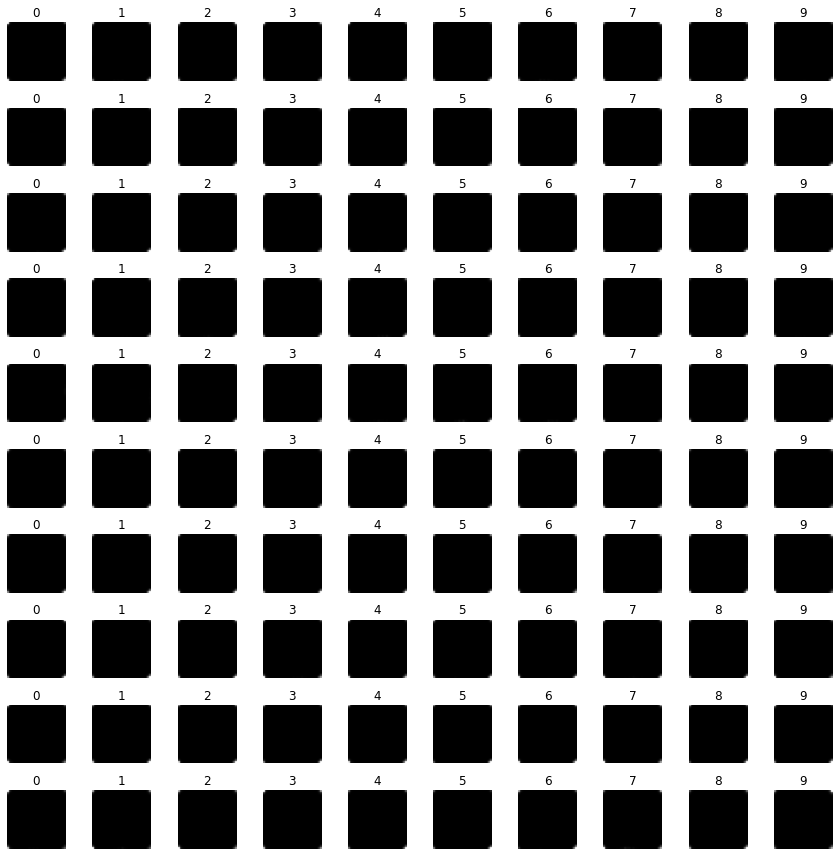

Epoch: 02/20 || Iterations: 0000/1071 || Loss G: 6.78519 || Loss D: 0.16689
Epoch: 02/20 || Iterations: 0400/1071 || Loss G: 7.15346 || Loss D: 0.16418
Epoch: 02/20 || Iterations: 0800/1071 || Loss G: 6.46087 || Loss D: 0.16556


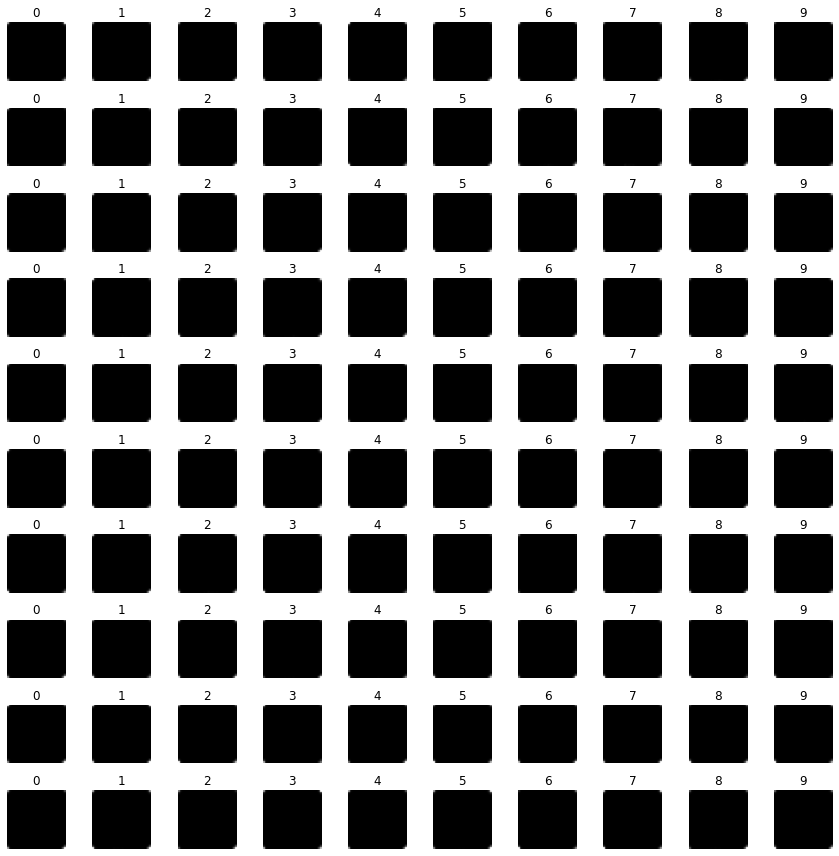

Epoch: 03/20 || Iterations: 0000/1071 || Loss G: 8.15455 || Loss D: 0.16439
Epoch: 03/20 || Iterations: 0400/1071 || Loss G: 8.27986 || Loss D: 0.16369
Epoch: 03/20 || Iterations: 0800/1071 || Loss G: 8.15437 || Loss D: 0.16324


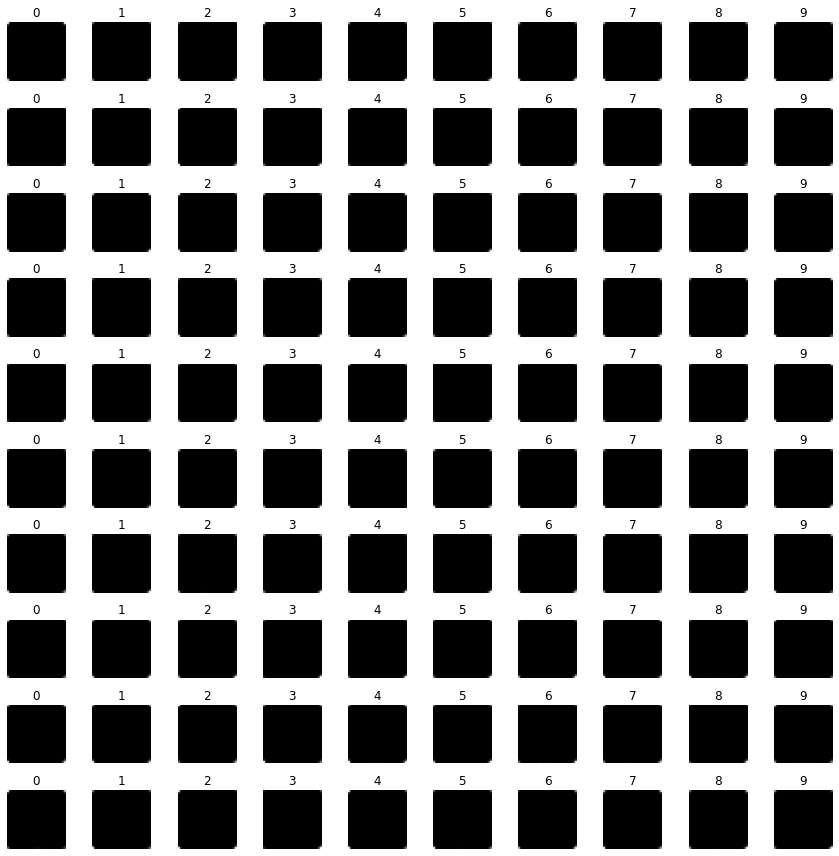

Epoch: 04/20 || Iterations: 0000/1071 || Loss G: 8.10447 || Loss D: 0.16319
Epoch: 04/20 || Iterations: 0400/1071 || Loss G: 8.38004 || Loss D: 0.16365
Epoch: 04/20 || Iterations: 0800/1071 || Loss G: 6.41259 || Loss D: 0.16595


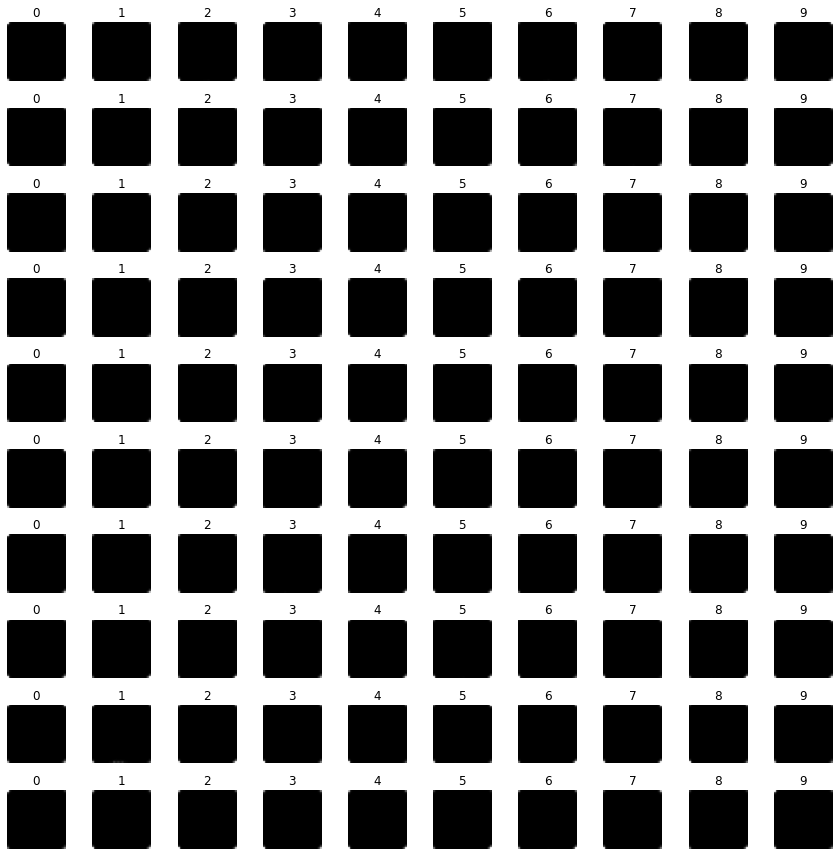

Epoch: 05/20 || Iterations: 0000/1071 || Loss G: 8.6577 || Loss D: 0.16291
Epoch: 05/20 || Iterations: 0400/1071 || Loss G: 9.59242 || Loss D: 0.1629
Epoch: 05/20 || Iterations: 0800/1071 || Loss G: 8.92785 || Loss D: 0.16611


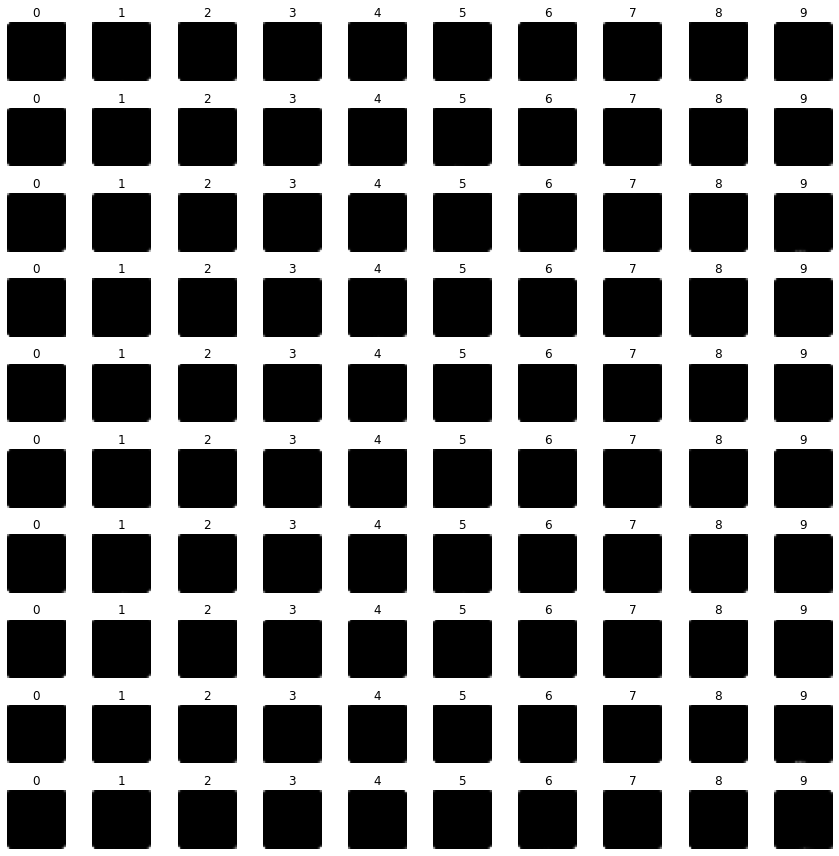

Epoch: 06/20 || Iterations: 0000/1071 || Loss G: 9.65037 || Loss D: 0.16281
Epoch: 06/20 || Iterations: 0400/1071 || Loss G: 9.85213 || Loss D: 0.16272
Epoch: 06/20 || Iterations: 0800/1071 || Loss G: 10.37352 || Loss D: 0.16275


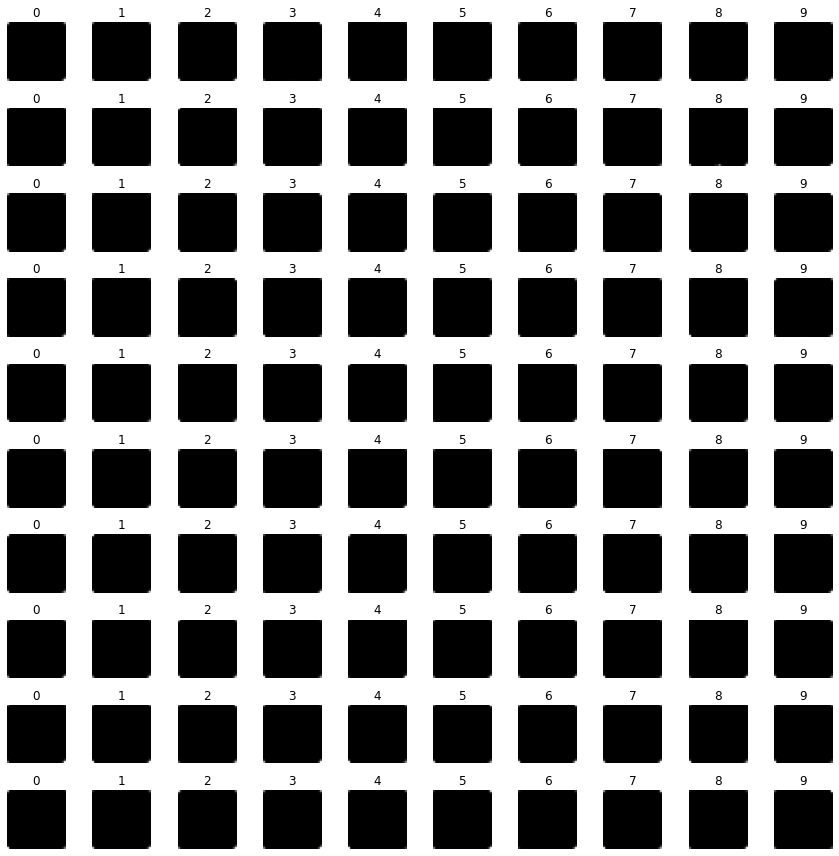

Epoch: 07/20 || Iterations: 0000/1071 || Loss G: 10.34824 || Loss D: 0.16278
Epoch: 07/20 || Iterations: 0400/1071 || Loss G: 10.40174 || Loss D: 0.16271
Epoch: 07/20 || Iterations: 0800/1071 || Loss G: 9.70387 || Loss D: 0.16275


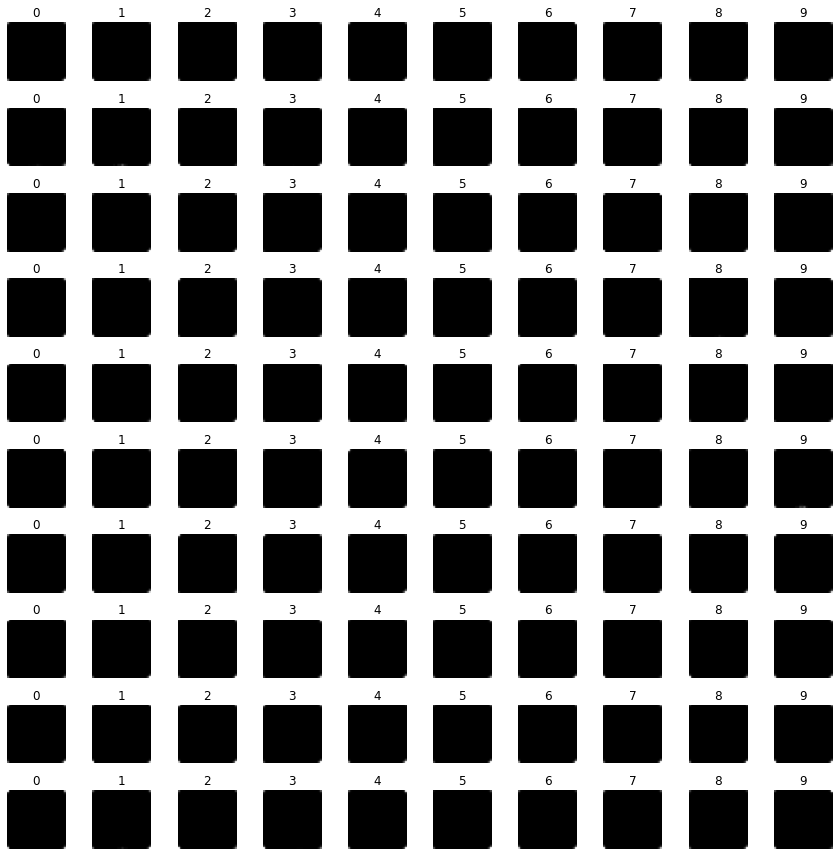

Epoch: 08/20 || Iterations: 0000/1071 || Loss G: 9.85753 || Loss D: 0.16287
Epoch: 08/20 || Iterations: 0400/1071 || Loss G: 10.52733 || Loss D: 0.16265
Epoch: 08/20 || Iterations: 0800/1071 || Loss G: 10.56996 || Loss D: 0.1628


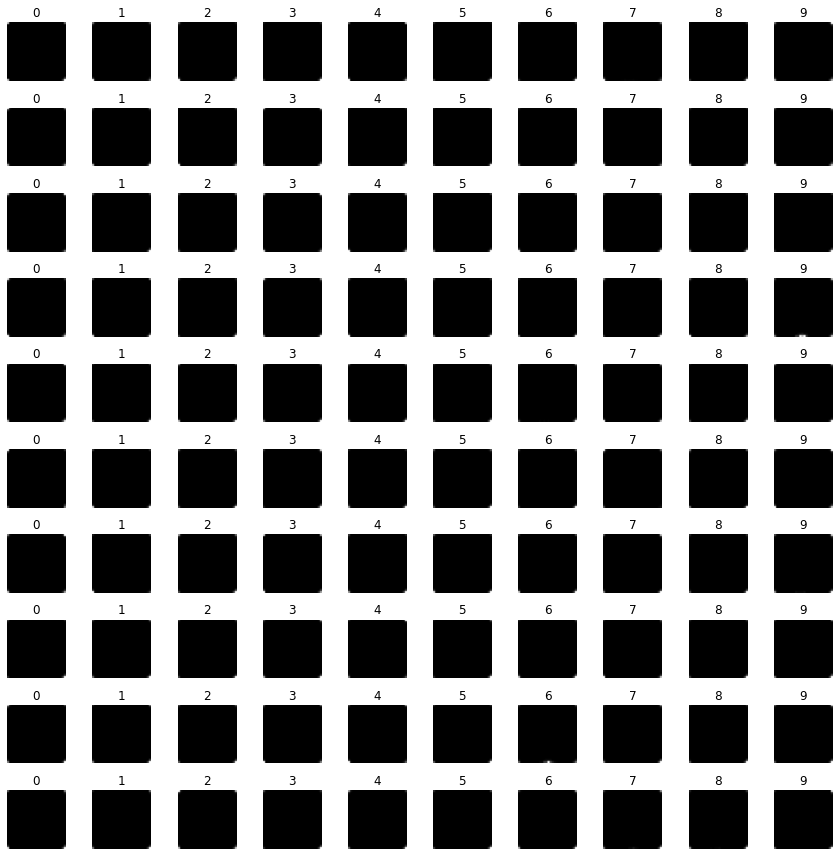

Epoch: 09/20 || Iterations: 0000/1071 || Loss G: 10.64748 || Loss D: 0.16271
Epoch: 09/20 || Iterations: 0400/1071 || Loss G: 10.0466 || Loss D: 0.16282
Epoch: 09/20 || Iterations: 0800/1071 || Loss G: 10.10358 || Loss D: 0.1627


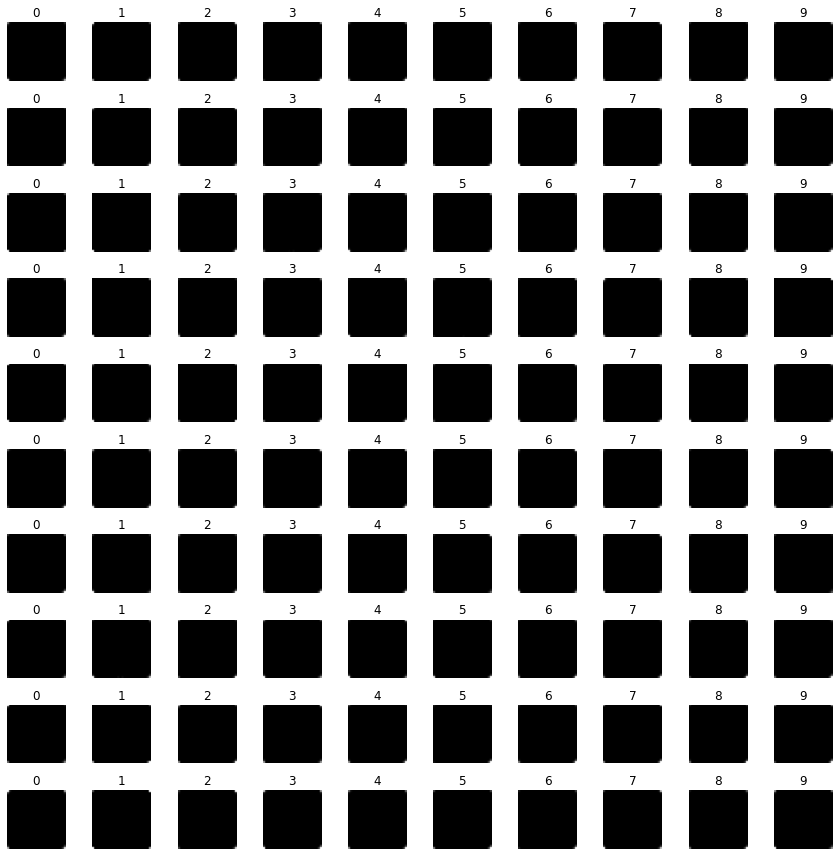

Epoch: 10/20 || Iterations: 0000/1071 || Loss G: 11.15226 || Loss D: 0.16274
Epoch: 10/20 || Iterations: 0400/1071 || Loss G: 11.83431 || Loss D: 0.16273
Epoch: 10/20 || Iterations: 0800/1071 || Loss G: 11.03514 || Loss D: 0.16279


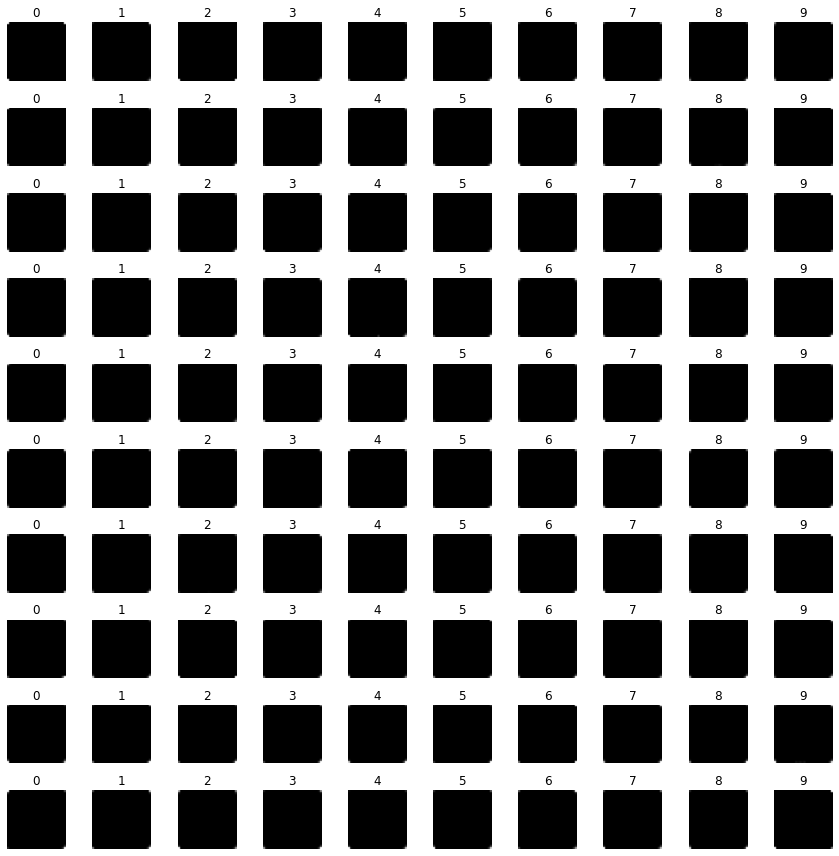

Epoch: 11/20 || Iterations: 0000/1071 || Loss G: 11.45434 || Loss D: 0.16267
Epoch: 11/20 || Iterations: 0400/1071 || Loss G: 11.00332 || Loss D: 0.16268
Epoch: 11/20 || Iterations: 0800/1071 || Loss G: 11.45435 || Loss D: 0.16269


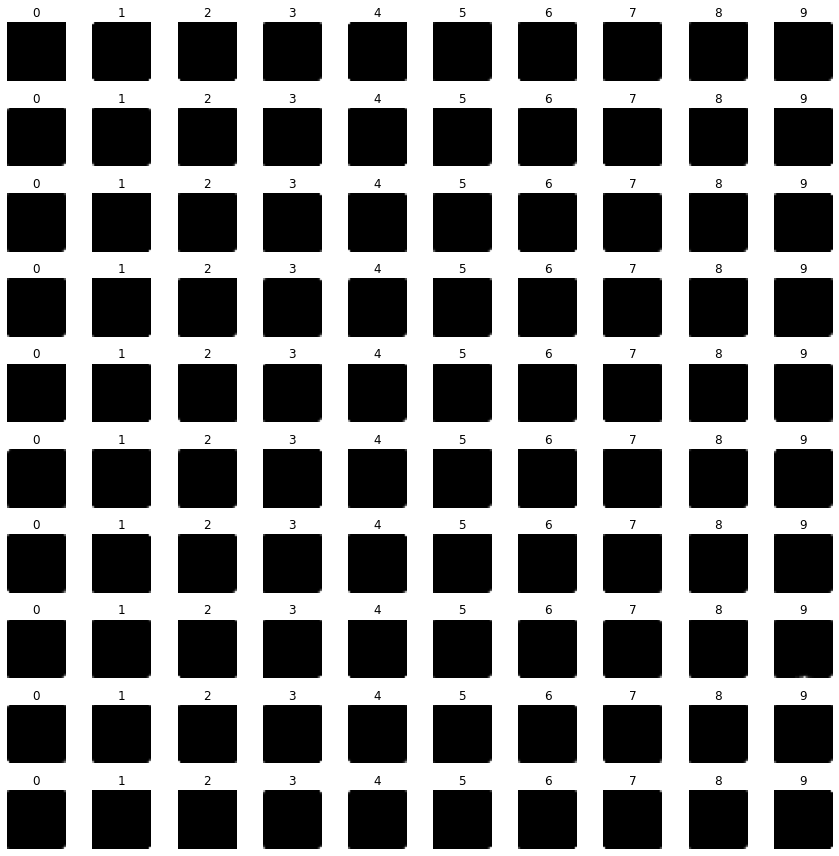

Epoch: 12/20 || Iterations: 0000/1071 || Loss G: 10.46056 || Loss D: 0.16273
Epoch: 12/20 || Iterations: 0400/1071 || Loss G: 11.0041 || Loss D: 0.16283
Epoch: 12/20 || Iterations: 0800/1071 || Loss G: 11.61953 || Loss D: 0.16271


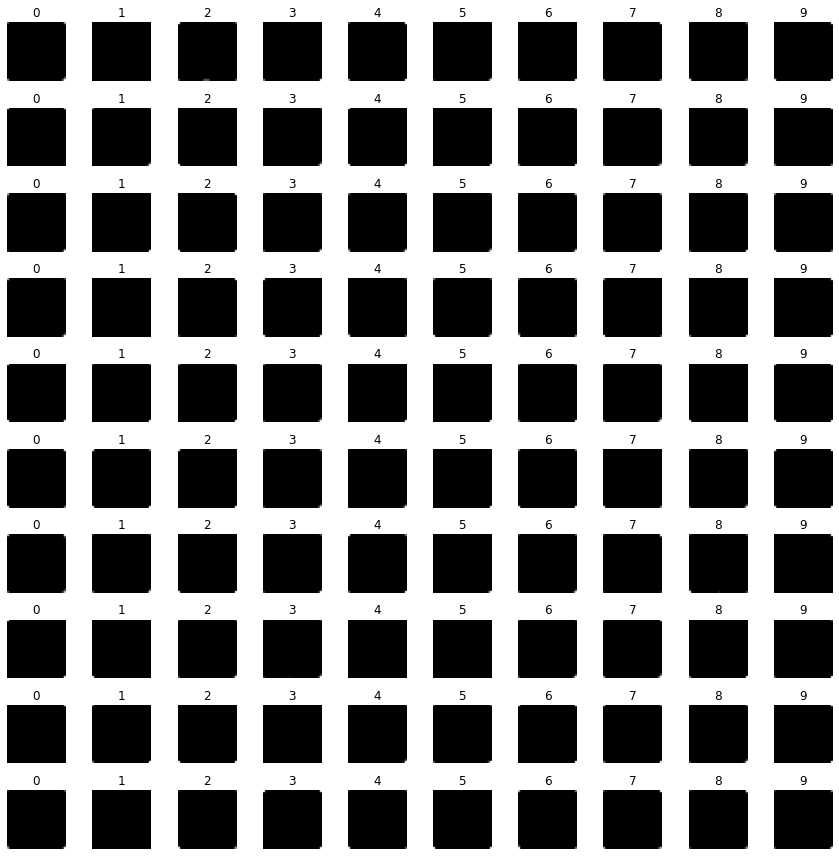

Epoch: 13/20 || Iterations: 0000/1071 || Loss G: 11.45338 || Loss D: 0.16273
Epoch: 13/20 || Iterations: 0400/1071 || Loss G: 10.85689 || Loss D: 0.16359
Epoch: 13/20 || Iterations: 0800/1071 || Loss G: 8.83437 || Loss D: 0.16311


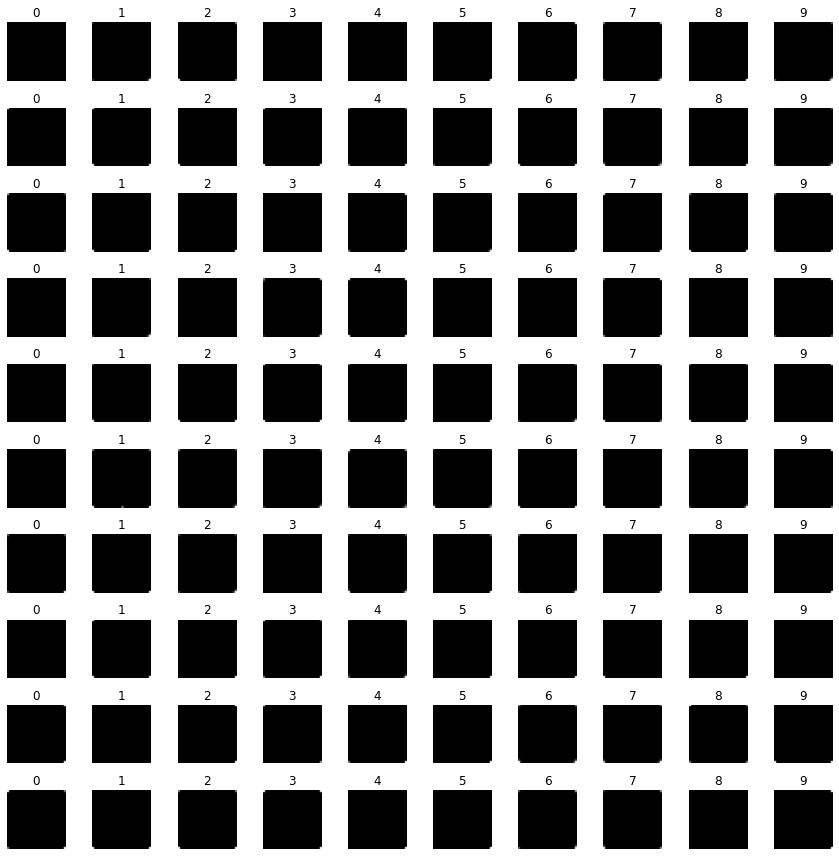

Epoch: 14/20 || Iterations: 0000/1071 || Loss G: 10.06692 || Loss D: 0.16413
Epoch: 14/20 || Iterations: 0400/1071 || Loss G: 9.35626 || Loss D: 0.16275
Epoch: 14/20 || Iterations: 0800/1071 || Loss G: 10.80115 || Loss D: 0.16266


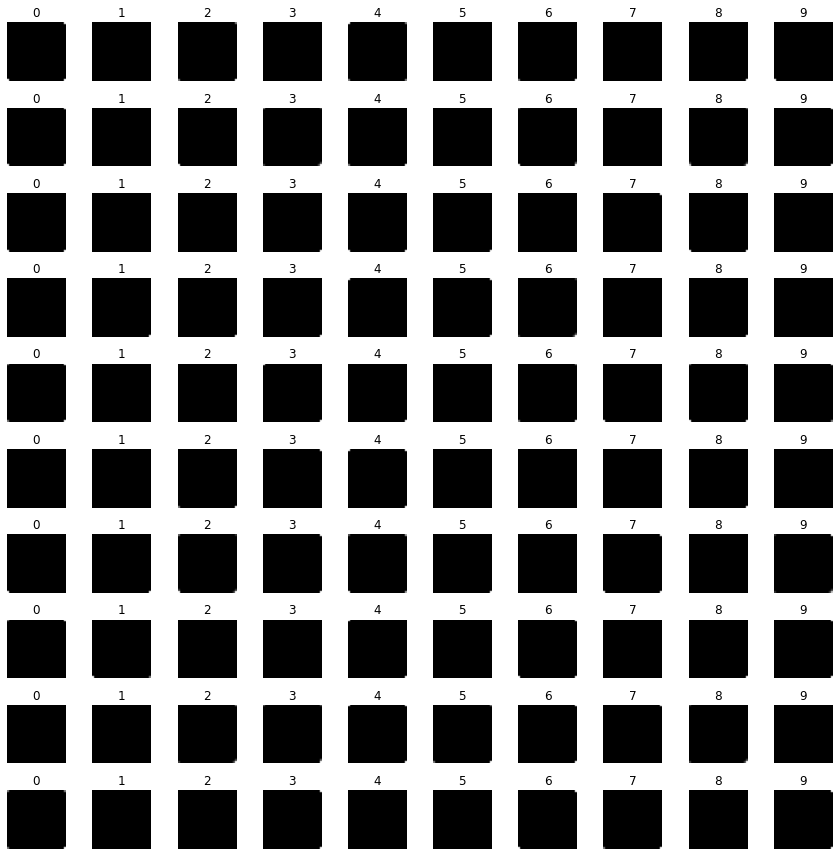

Epoch: 15/20 || Iterations: 0000/1071 || Loss G: 10.59494 || Loss D: 0.16273
Epoch: 15/20 || Iterations: 0400/1071 || Loss G: 11.63577 || Loss D: 0.16266
Epoch: 15/20 || Iterations: 0800/1071 || Loss G: 10.50387 || Loss D: 0.16272


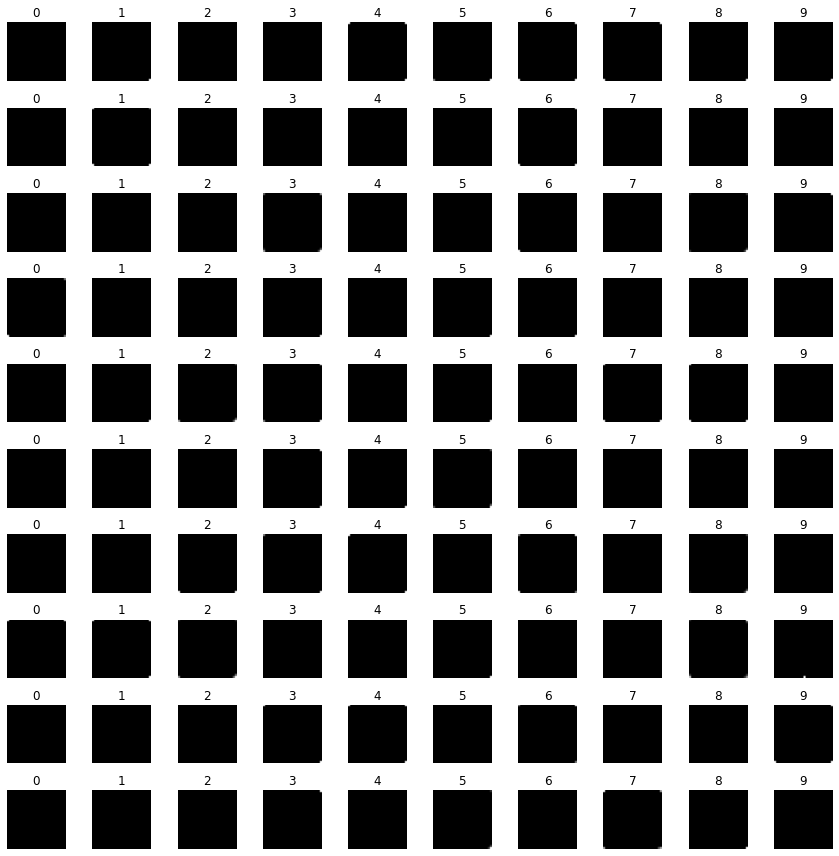

Epoch: 16/20 || Iterations: 0000/1071 || Loss G: 11.39986 || Loss D: 0.16274
Epoch: 16/20 || Iterations: 0400/1071 || Loss G: 11.24712 || Loss D: 0.16293
Epoch: 16/20 || Iterations: 0800/1071 || Loss G: 10.26622 || Loss D: 0.16353


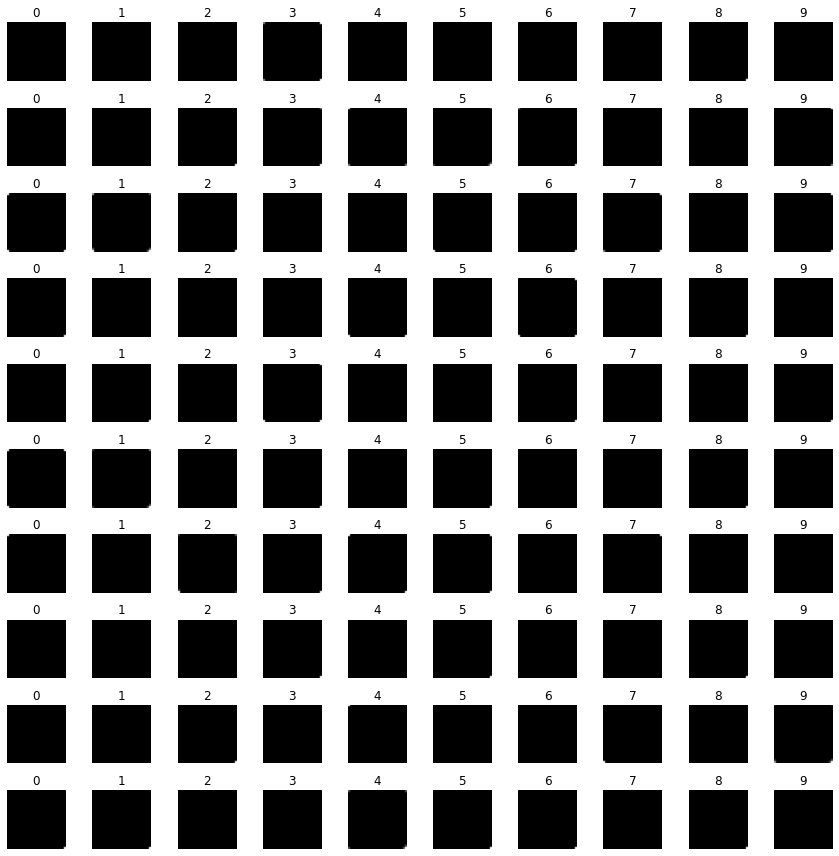

Epoch: 17/20 || Iterations: 0000/1071 || Loss G: 10.62572 || Loss D: 0.16267
Epoch: 17/20 || Iterations: 0400/1071 || Loss G: 11.25344 || Loss D: 0.16264
Epoch: 17/20 || Iterations: 0800/1071 || Loss G: 11.00094 || Loss D: 0.16275


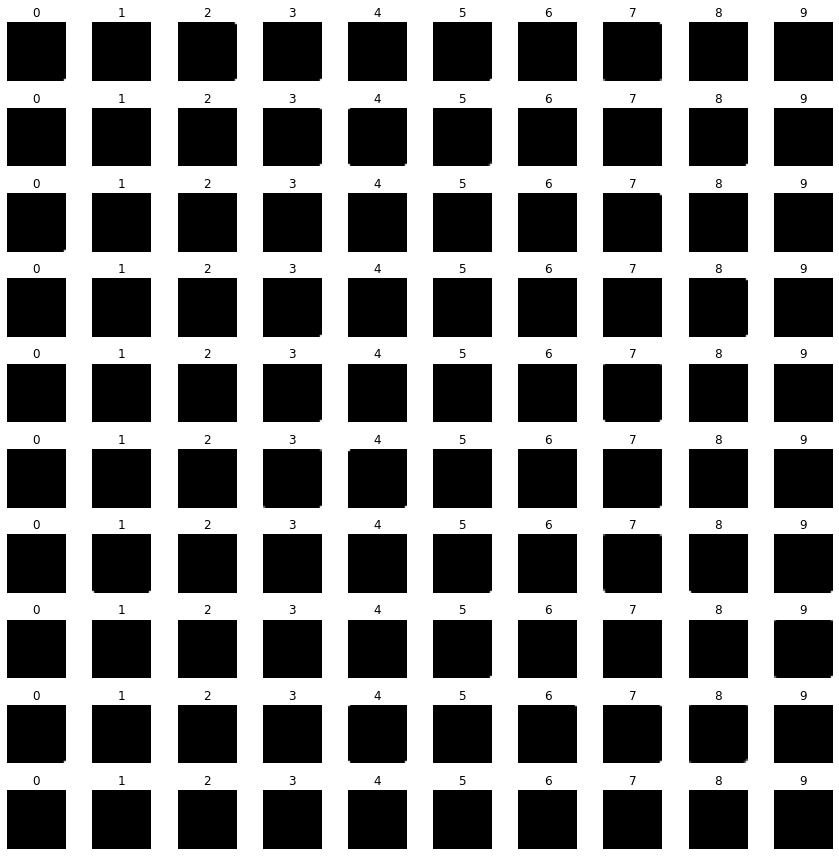

Epoch: 18/20 || Iterations: 0000/1071 || Loss G: 10.7639 || Loss D: 0.16265
Epoch: 18/20 || Iterations: 0400/1071 || Loss G: 11.92383 || Loss D: 0.16274
Epoch: 18/20 || Iterations: 0800/1071 || Loss G: 12.67996 || Loss D: 0.16262


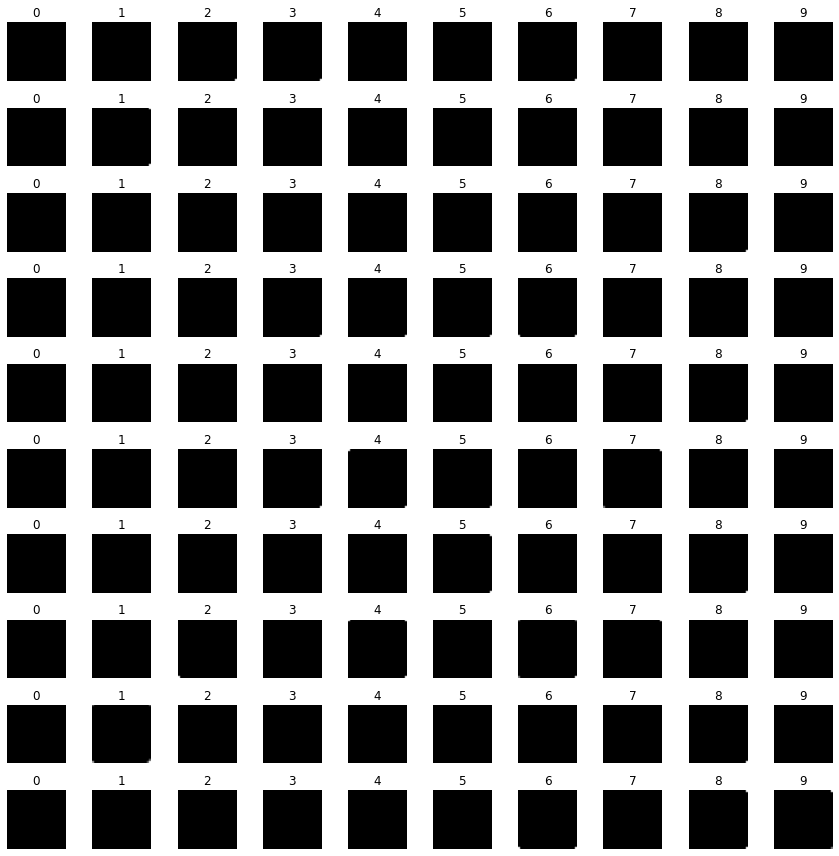

Epoch: 19/20 || Iterations: 0000/1071 || Loss G: 11.70665 || Loss D: 0.16265
Epoch: 19/20 || Iterations: 0400/1071 || Loss G: 11.1935 || Loss D: 0.16271
Epoch: 19/20 || Iterations: 0800/1071 || Loss G: 12.10941 || Loss D: 0.1627


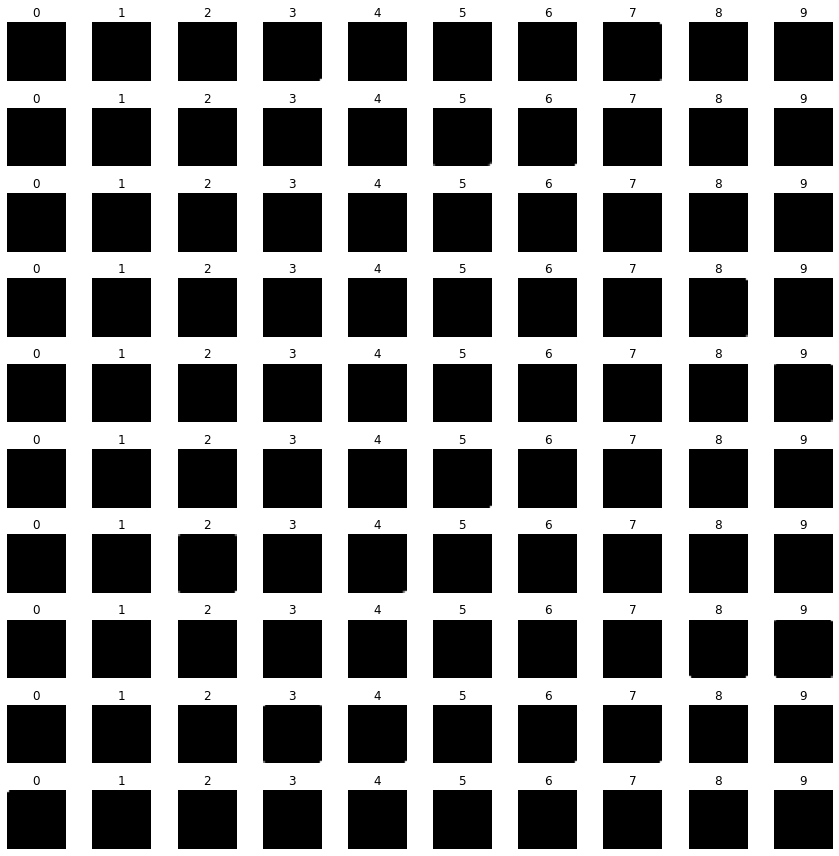

Epoch: 20/20 || Iterations: 0000/1071 || Loss G: 11.65062 || Loss D: 0.1627
Epoch: 20/20 || Iterations: 0400/1071 || Loss G: 12.02681 || Loss D: 0.16263
Epoch: 20/20 || Iterations: 0800/1071 || Loss G: 11.05553 || Loss D: 0.16263


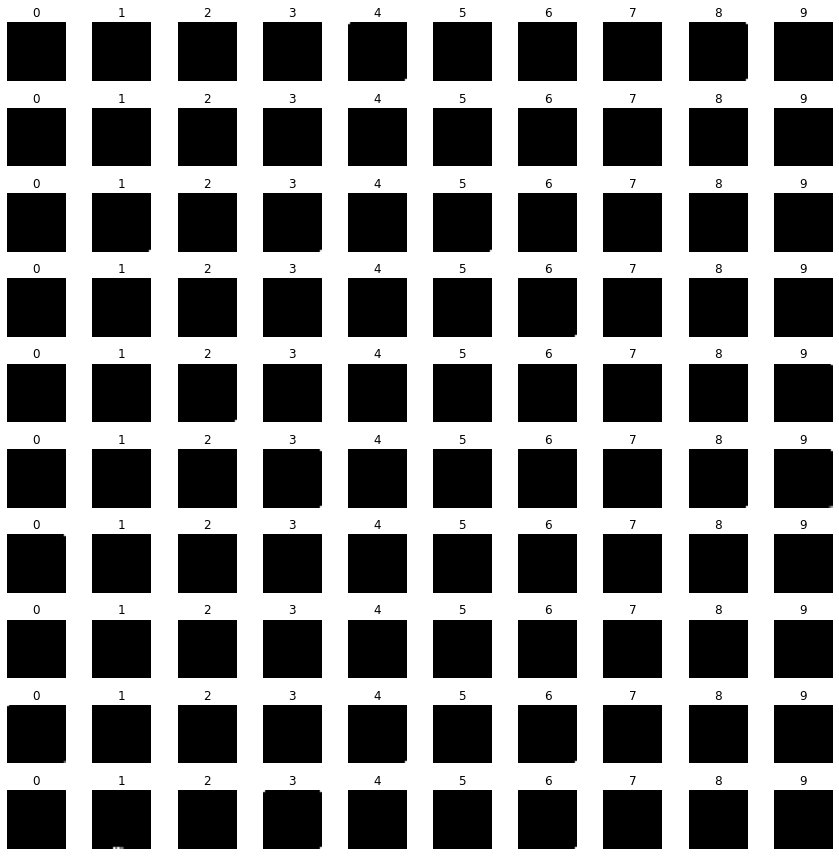

In [16]:
t_gan_c.fit(train_loader, epoch=20)

# Generate digits with trained model

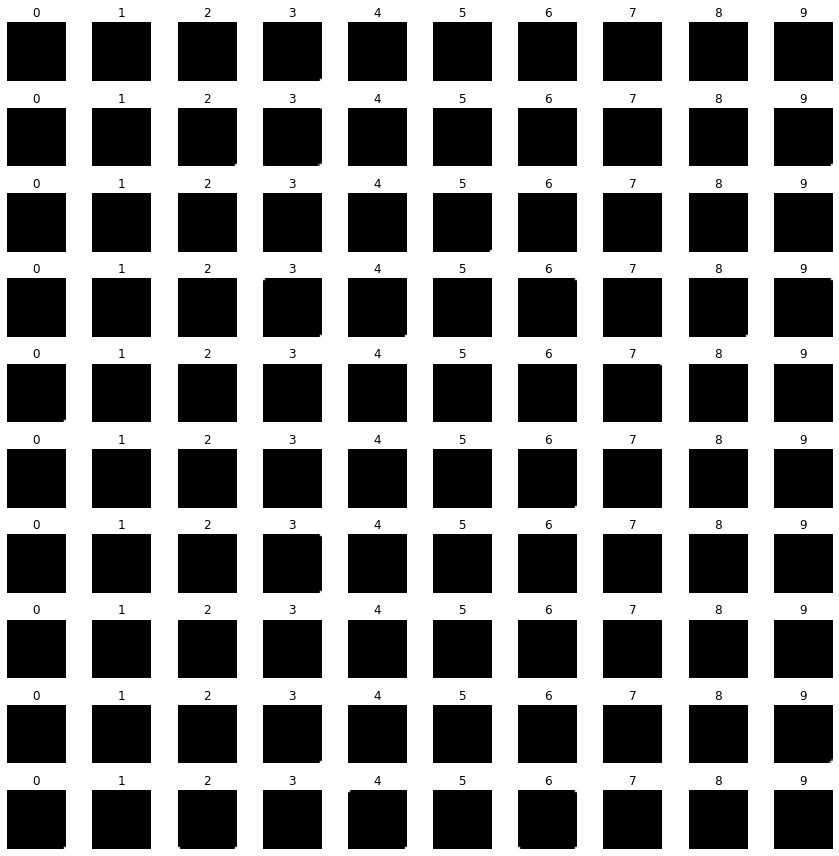

In [17]:
# Check generator
num_data = NUM_CLASSES * NUM_CLASSES
arr = np.random.randn(num_data, NOISE_SIZE).astype(np.float32)
labels_arr = np.asarray(
    [min(x, NUM_CLASSES-1)  for _ in range(NUM_CLASSES) for x in range(NUM_CLASSES)],
    dtype=np.int64
)
gen_nn.eval()
res = gen_nn(torch.tensor(arr).to(device=device), torch.tensor(labels_arr).to(device=device))
# Unnormed images and plot big figure
res = ((res + 1.0) / 2.0).cpu().detach().numpy().transpose(0, 2, 3, 1)
visualise_sheets_of_images(res, NUM_CLASSES, "generated_digits", show_images=True, use_grey=True)

# Save model

In [18]:
torch.save(gen_nn.state_dict(), 'model.pth')

In [19]:
NOISE_SIZE

128

# Create ONNX model
Create onnx model and we can download it from output tab on the right side

In [20]:
dummy_noise = torch.randn(1, NOISE_SIZE,dtype=torch.float).to(device='cuda')
dummy_label = torch.randint(0, high=9, size=(1,1), dtype=torch.long).to(device='cuda')
dummy_noise, dummy_label

(tensor([[ 8.4253e-01, -8.3732e-02,  1.3821e+00, -1.2614e+00,  5.6627e-01,
           1.2236e+00, -2.3807e+00,  3.6457e-01, -1.0159e+00, -1.5463e+00,
           2.9500e-01,  2.1073e+00, -7.4604e-02, -1.7769e+00, -1.8026e+00,
           6.0119e-02,  6.1880e-02,  4.9152e-01, -3.6971e-01,  4.2279e-02,
           8.0636e-01, -3.3861e-01, -3.0742e-01,  3.0078e-01,  1.6361e-01,
          -9.5653e-01, -3.6768e-01, -7.1281e-01, -6.9890e-01,  5.3696e-01,
          -1.3219e-01,  2.9633e-01,  2.0299e-01,  1.2214e-01, -5.1811e-01,
          -3.4438e-01,  1.0403e-01,  1.6015e-01,  1.3466e+00,  7.3922e-01,
          -9.3263e-01,  6.0494e-02,  9.3859e-01, -4.5354e-02,  1.9437e+00,
           7.3938e-01,  5.2601e-04, -2.5058e-01,  2.7411e-01,  1.3779e+00,
          -4.1684e+00,  1.2099e+00, -2.7359e-01,  1.5470e-01,  5.0132e-01,
           1.5275e+00,  9.7973e-01, -1.5396e+00,  6.4112e-01, -1.2454e+00,
           9.3792e-02, -7.8745e-01, -2.7212e+00,  2.2467e+00, -1.1804e+00,
          -1.5085e+00,  8

In [21]:
torch.onnx.export(
    gen_nn, (dummy_noise, dummy_label), "model_fashion.onnx", verbose=True
)

graph(%input.3 : Float(1:128, 128:1, requires_grad=0, device=cuda:0),
      %input.1 : Long(1:1, 1:1, requires_grad=0, device=cuda:0),
      %_embed_input.0.weight : Float(10:48, 48:1, requires_grad=1, device=cuda:0),
      %_embed_input.1.bias : Float(49:1, requires_grad=1, device=cuda:0),
      %_noise_input.0.weight : Float(6272:128, 128:1, requires_grad=1, device=cuda:0),
      %_noise_input.0.bias : Float(6272:1, requires_grad=1, device=cuda:0),
      %_model.0.weight : Float(129:2048, 128:16, 4:4, 4:1, requires_grad=1, device=cuda:0),
      %_model.0.bias : Float(128:1, requires_grad=1, device=cuda:0),
      %_model.2.weight : Float(128:2048, 128:16, 4:4, 4:1, requires_grad=1, device=cuda:0),
      %_model.2.bias : Float(128:1, requires_grad=1, device=cuda:0),
      %_model.4.weight : Float(1:6272, 128:49, 7:7, 7:1, requires_grad=1, device=cuda:0),
      %_model.4.bias : Float(1:1, requires_grad=1, device=cuda:0),
      %47 : Float(48:1, 49:48, requires_grad=0, device=cuda:0),
  